In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

%matplotlib inline

In [2]:
# pandas' options
pd.set_option('max_columns', None)

**Challenge 1: can't open the JSON file correctly** [sol](https://towardsdatascience.com/how-to-convert-json-into-a-pandas-dataframe-100b2ae1e0d8)

In [3]:
with open('../data/movies.json','r') as f:
    data = json.loads(f.read())

# Flatten data
movies = pd.json_normalize(data, record_path =['results'])

In [4]:
with open('../data/series.json', 'r') as f:
    data = json.loads(f.read())

series = pd.json_normalize(data, record_path=['results'])

# Data Preprocessing

## Formatting Released Date

### For series

In [5]:
series['description'] = series['description'].apply(lambda x: x.strip('()').split('–')[0])

In [6]:
series[~series['description'].str.isnumeric()]['description']

47      I) (2021
110     I) (2021
162             
235    II) (2021
240             
Name: description, dtype: object

In [7]:
# changing some value by hand
series.loc[47, 'description'] = '2021'
series.loc[110, 'description'] = '2021'
series.loc[235, 'description'] = '2021'

In [8]:
series[~series['description'].str.isnumeric()]['description']

162    
240    
Name: description, dtype: object

In [9]:
# dropping non-existant values
indexes = series[~series['description'].str.isnumeric()].index
series.drop(indexes, axis=0, inplace=True)

### For movies

In [10]:
movies['description'] = movies['description'].apply(lambda x: x.strip('()').split()[0])

In [11]:
movies[~movies['description'].str.isnumeric()]['description']

23    TV
33    TV
Name: description, dtype: object

In [12]:
indexes = movies[~movies['description'].str.isnumeric()].index
movies.drop(indexes, axis=0, inplace=True)

In [13]:
movies[~movies['description'].str.isnumeric()]['description']

Series([], Name: description, dtype: object)

## Adding type column

In [14]:
movies['type'] = 'Movie'
series['type'] = 'Series'

## Appending the two series

In [15]:
works = series.append(movies, ignore_index=True)

## Drop unnecessary columns

In [16]:
works.drop(['runtimeStr', 'contentRating', 'metacriticRating', 'plot', 'stars', 'starList'], axis=1, inplace=True)

## Changing the numerical datatypes

In [17]:
indexes = works[works['imDbRatingVotes'].isnull()].index
works.loc[indexes, 'imDbRatingVotes'] = 0

In [18]:
works['imDbRatingVotes'] = works['imDbRatingVotes'].astype('int')
works['imDbRating'] = works['imDbRating'].astype('float')
works['description'] = works['description'].astype('int')

## Separate the genres

**Challenge 2: can't separate the genres.** [sol](https://www.geeksforgeeks.org/python-convert-a-string-representation-of-list-into-list/)

In [19]:
# works that doesn't have any genres
works[works['genres'].isnull()]

,id,image,title,description,genres,genreList,imDbRating,imDbRatingVotes,type
282,tt3253984,https://imdb-api.com/images/original/nopicture...,Howa Al Naharda Aih,2007,None,None,NaN,0,Movie
289,tt3254058,https://imdb-api.com/images/original/nopicture...,Tarh El Sabbar,2006,None,None,NaN,0,Movie


In [20]:
# remove the 3 instance where it has no genres
indexes = works[works['genres'].isnull()].index
works.drop(indexes, inplace=True)
works.reset_index(drop=True, inplace=True)

In [21]:
works['no_of_genres'] = works['genres'].apply(lambda x: len(x.split(', ')))

In [22]:
# the max number of genres that a individual movie has
np.max(works['no_of_genres'])

3

In [23]:
# what are the distinct genres with the rows that has one genre
works['genres'][works['no_of_genres'] == 1].value_counts()

Drama          82
Comedy         41
Action          8
Documentary     8
Thriller        7
Musical         3
Talk-Show       2
Crime           2
Romance         2
Horror          2
History         2
Mystery         2
Fantasy         1
Animation       1
Adventure       1
Biography       1
Music           1
Name: genres, dtype: int64

In [24]:
# get all the unique genres
unique_genres = []
for genre_list in works['genres'].str.strip('][').str.split(', '):
    for genre in genre_list:
        if genre not in unique_genres:
            unique_genres.append(genre)
            
print(unique_genres)

['Drama', 'Fantasy', 'Horror', 'Comedy', 'Romance', 'Action', 'Biography', 'Thriller', 'History', 'War', 'Mystery', 'Adventure', 'Crime', 'Sci-Fi', 'Family', 'Music', 'Musical', 'Talk-Show', 'Reality-TV', 'Animation', 'Short', 'Documentary']


In [25]:
# there are 22 unique genres
len(unique_genres)

22

In [26]:
works.shape

(297, 10)

In [27]:
# create 22 different columns representing the different genres
for unique_genre in unique_genres:
    works[unique_genre] = 0

In [28]:
works.shape

(297, 32)

In [29]:
# changing the value of the corresponding genre into 1
for index, genre_list in enumerate(works['genres'].str.strip('][').str.split(', ')):
    for genre in genre_list:
        works.loc[index, genre] = 1

In [30]:
works.head(2)

,id,image,title,description,genres,genreList,imDbRating,imDbRatingVotes,type,no_of_genres,Drama,Fantasy,Horror,Comedy,Romance,Action,Biography,Thriller,History,War,Mystery,Adventure,Crime,Sci-Fi,Family,Music,Musical,Talk-Show,Reality-TV,Animation,Short,Documentary
0,tt19495202,https://imdb-api.com/images/original/MV5BNDNjN...,Suits,2022,Drama,"[{'key': 'Drama', 'value': 'Drama'}]",7.4,179,Series,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,tt12411074,https://imdb-api.com/images/original/MV5BNGY1Y...,Paranormal,2020,"Drama, Fantasy, Horror","[{'key': 'Drama', 'value': 'Drama'}, {'key': '...",8.0,71528,Series,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
# removing the genres and genreList columns
works.drop(['genres', 'genreList'], axis=1, inplace=True)

# Answering Questions

## Q1) how many works/series have been made in each genre?

In [32]:
summations = []
for genre in unique_genres:
    summations.append(np.sum(works[genre]))

no_works_in_genre = pd.Series(summations, index=unique_genres).sort_values(ascending=False)

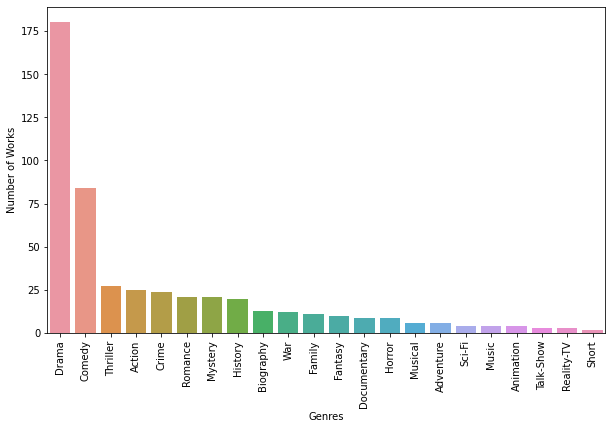

In [33]:
plt.figure(figsize=(10, 6))
sns.barplot(x=no_works_in_genre.index, y=no_works_in_genre.values)
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Number of Works');

## Q2) How many works have been made each year?

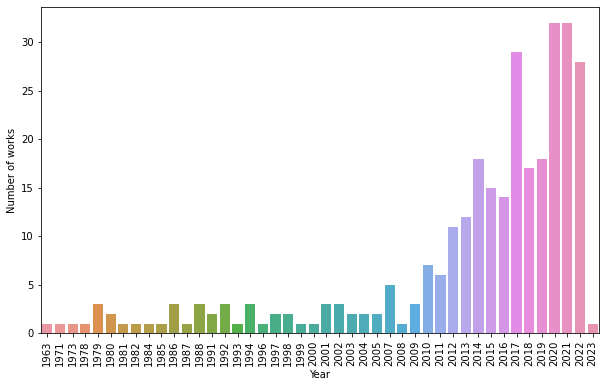

In [34]:
works_per_year = works[['id', 'description']].groupby(by='description', as_index=False).count()
plt.figure(figsize=(10, 6))
sns.barplot(x='description', y='id', data=works_per_year)
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Number of works');

## Q3) What is the average rating for movies and series?

In [35]:
# the number of missing ratings
series['imDbRating'].isnull().sum()
movies['imDbRating'].isnull().sum()

10

34

In [36]:
works[works['type'] == 'Movie']['imDbRating'].mean()
works[works['type'] == 'Series']['imDbRating'].mean()
works['imDbRating'].mean()

6.7176470588235295

6.726050420168067

6.725490196078432